# Splits = 60 : estimation de la loi d'Amdahl

Objectif :
- garder uniquement les mesures avec `splits = 60` dans `benchmarks/results.jsonl`
- tracer les speedups mesurés vs le nombre de workers et ajuster une loi d'Amdahl proche des points
- estimer le taux de parallélisation (`1 - s`) en extrapolant la référence `T1`
- montrer la variabilité quand plusieurs runs existent pour un même couple (workers, splits) et en discuter les causes


In [67]:
from __future__ import annotations
import json
import math
from collections import defaultdict
from pathlib import Path
from statistics import median, fmean
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt

try:
    import pandas as pd  # facultatif
except ImportError:  # pragma: no cover
    pd = None

plt.rcParams.update({"figure.figsize": (8,5), "axes.grid": True})


In [68]:
DATA_PATH = Path("benchmarks/results.jsonl")
rows = [json.loads(line) for line in DATA_PATH.read_text().splitlines() if line.strip()]
rows60 = [r for r in rows if int(r.get("splits", -1)) == 60]
print(f"Nombre de mesures splits=60: {len(rows60)}")

rows60 = sorted(rows60, key=lambda r: (int(r["workers"]), float(r["duration_seconds"])))
if pd is not None:
    display(pd.DataFrame(rows60)[["workers", "splits", "duration_seconds"]])
else:
    for rec in rows60:
        print(rec["workers"], rec["duration_seconds"])


Nombre de mesures splits=60: 35


,workers,splits,duration_seconds
0,5,60,1009.850181
1,6,60,788.960479
2,6,60,836.309789
3,6,60,855.447202
4,10,60,431.295248
5,10,60,449.325008
6,10,60,456.072934
7,10,60,470.955971
8,10,60,550.164007
9,12,60,356.456169


## Agrégation par nombre de workers
On regroupe les durées par `workers` pour observer la dispersion (min/median/max).


In [69]:
def summarize_by_workers(data: List[dict]) -> Dict[int, dict]:
    grouped: Dict[int, List[float]] = defaultdict(list)
    for rec in data:
        grouped[int(rec["workers"])] .append(float(rec["duration_seconds"]))
    summary: Dict[int, dict] = {}
    for w, durations in grouped.items():
        durations_sorted = sorted(durations)
        summary[w] = {
            "count": len(durations_sorted),
            "min": durations_sorted[0],
            "max": durations_sorted[-1],
            "median": median(durations_sorted),
            "mean": fmean(durations_sorted),
        }
    return dict(sorted(summary.items()))

summary = summarize_by_workers(rows60)
if pd is not None:
    display(pd.DataFrame.from_dict(summary, orient="index"))
else:
    for w, stats in summary.items():
        print(w, stats)


,count,min,max,median,mean
5,1,1009.850181,1009.850181,1009.850181,1009.850181
6,3,788.960479,855.447202,836.309789,826.905824
10,5,431.295248,550.164007,456.072934,471.562633
12,5,356.456169,905.104458,373.076629,495.398502
15,5,285.940447,731.728135,330.485391,419.771938
20,5,219.660001,386.447481,278.743315,289.499879
30,5,151.241938,214.607220,152.711474,174.293980
60,5,85.077196,293.890013,162.206331,183.283605
120,1,90.104458,90.104458,90.104458,90.104458


## Ajustement d'Amdahl sur les durées (référence extrapolée)
On cherche `s` (fraction séquentielle) et `T1` (durée pour 1 worker) tels que :
\[ T(N) = T1 \cdot \left(s + 
rac{1 - s}{N}
ight) \]
Pour un `s` donné, la meilleure valeur `T1` se déduit par moindres carrés. On balaye `s` dans [0, 0.5] et on retient le couple (`s`, `T1`) minimisant l'erreur quadratique sur toutes les mesures.


In [70]:
def fit_amdahl(durations: List[Tuple[int, float]], s_min=0.0, s_max=0.5, steps=2000) -> Tuple[float, float]:
    best_s, best_T1, best_err = math.nan, math.nan, float("inf")
    for i in range(steps + 1):
        s = s_min + (s_max - s_min) * i / steps
        phis = []
        ys = []
        for w, t in durations:
            phi = s + (1 - s) / w
            phis.append(phi)
            ys.append(t)
        denom = sum(phi * phi for phi in phis)
        if denom == 0:
            continue
        T1 = sum(y * phi for y, phi in zip(ys, phis)) / denom
        err = sum((y - T1 * phi) ** 2 for y, phi in zip(ys, phis))
        if err < best_err:
            best_err, best_s, best_T1 = err, s, T1
    return best_s, best_T1

all_points = [(int(r["workers"]), float(r["duration_seconds"])) for r in rows60]
s_hat, T1_hat = fit_amdahl(all_points)
parallel_rate = 1 - s_hat
print(f"s ≈ {s_hat:.4f}, T1 ≈ {T1_hat:.2f} s, taux de parallélisation ≈ {parallel_rate*100:.2f}%")


s ≈ 0.0163, T1 ≈ 4603.01 s, taux de parallélisation ≈ 98.38%


## Speedups mesurés vs modèle d'Amdahl
- Speedup mesuré : \( S(N) = T1_{fit} / T(N) \) avec `T1` extrapolée.
- Courbe théorique : \( S_{th}(N) = 1 / (s + (1 - s)/N) \).
- Les barres d'erreur montrent min/max pour chaque `workers` quand plusieurs runs existent (variabilité).


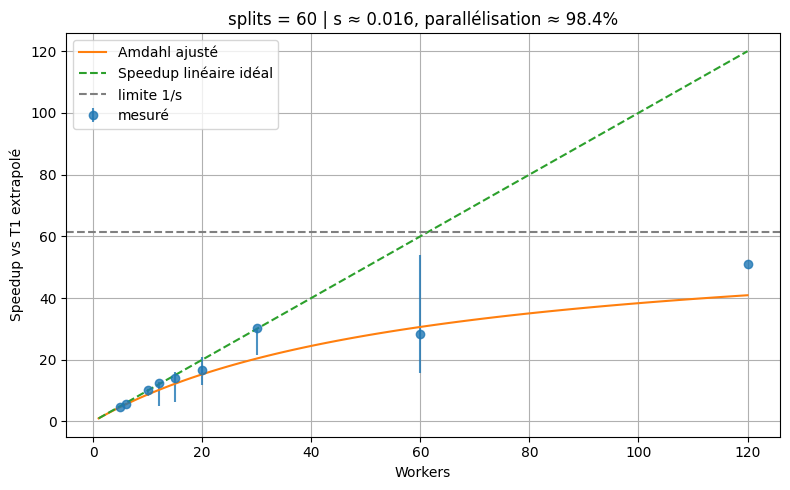

In [71]:
def compute_speedups(points: List[Tuple[int, float]], T1: float) -> List[Tuple[int, float]]:
    return [(w, T1 / t) for w, t in points if t > 0]

speedup_points = compute_speedups(all_points, T1_hat)
by_workers = defaultdict(list)
for w, s in speedup_points:
    by_workers[w].append(s)

# Ligne de référence f(x) = x (idéal linéaire sans overhead)
workers_sorted = sorted(by_workers.keys())
max_w = max(workers_sorted) if workers_sorted else 1
ref_workers = list(range(1, max_w + 1))
ref_linear = [w for w in ref_workers]

fig, ax = plt.subplots(figsize=(8,5))

for w, vals in sorted(by_workers.items()):
    vals_sorted = sorted(vals)
    med = median(vals_sorted)
    err_low = med - vals_sorted[0]
    err_high = vals_sorted[-1] - med
    ax.errorbar([w], [med], yerr=[[err_low],[err_high]], fmt='o', color='tab:blue', alpha=0.8, label='mesuré' if w == workers_sorted[0] else None)

theoretical = [1.0 / (s_hat + (1 - s_hat) / w) for w in ref_workers]
ax.plot(ref_workers, theoretical, label="Amdahl ajusté", color="tab:orange")
ax.plot(ref_workers, ref_linear, label="Speedup linéaire idéal", color="tab:green", linestyle="--")
ax.axhline(1/s_hat, color='tab:gray', linestyle='--', label='limite 1/s')
ax.set_xlabel("Workers")
ax.set_ylabel("Speedup vs T1 extrapolé")
ax.set_title(f"splits = 60 | s ≈ {s_hat:.3f}, parallélisation ≈ {parallel_rate*100:.1f}%")
ax.legend()
plt.tight_layout()
plt.show()


### Pourquoi la limite théorique paraît élevée
- Le plateau `1/s` (~62) vient de l'ajustement sur les données disponibles et reste une borne optimiste.
- On a peu de points au-delà de 60 workers et les overheads (réseau, I/O, scheduling) croissent avec `N`, donc le speedup réel plafonnera avant cette limite.
- La ligne f(x)=x est l'idéal linéaire et les points s'en écartent déjà, signe qu'on approche une asymptote plus basse que `1/s` théorique.
- Moralité : la limite Amdahl sert de plafond théorique, le plafond réaliste est guidé par les derniers points mesurés, avec de la variabilité (charge cluster, placement des splits).


## Commentaires sur la variabilité
- Pour un même `workers`, on observe des dispersions (barres min/max). Dans ce cluster partagé, les différences viennent surtout de la charge réseau/disque concurrente et du placement des splits (fichiers différents, formats légèrement hétérogènes).
- Les workers traitent leurs splits séquentiellement, mais chaque split exploite plusieurs cœurs (`ProcessPoolExecutor` dans `worker.py`). Quand `workers` divise exactement `splits`, il n'y a pas de splits empilés sur un même worker, d'où un palier d'efficacité élevé.
- Les RUN multiples reflètent aussi des aléas (congestion réseau, cache disque, contention CPU sur les nœuds). Les barres d'erreur sur le graphique matérialisent cette variabilité.
